# Assessing model evidence

In this tutorial we take a look at how to assess how many parameters may be statistically justified in a given transmission string. Let us start by simulating a high-precision transit light curve with a 4-parameter transmission string.

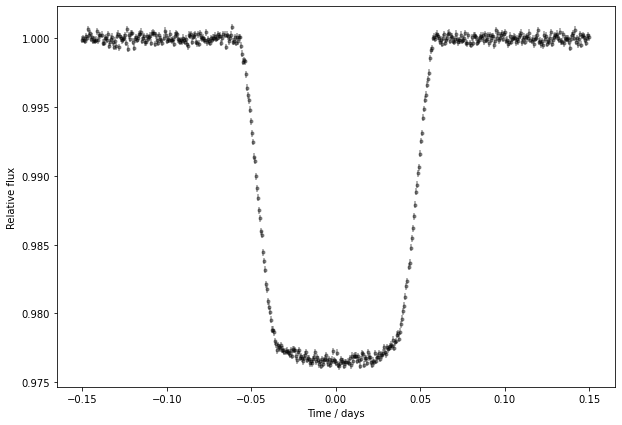

In [1]:
import numpy as np
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from harmonica import HarmonicaTransit


np.random.seed(12)

times = np.linspace(-0.15, 0.15, 500)
r_mean = np.array([0.15])
r_dev = np.random.uniform(-0.1, 0.1, size=3)
injected_r = np.concatenate([r_mean, r_dev * r_mean])

ht = HarmonicaTransit(times)
ht.set_orbit(t0=0., period=4., a=11., inc=87. * np.pi / 180.)
ht.set_stellar_limb_darkening(np.array([0.027, 0.246]), limb_dark_law='quadratic')
ht.set_planet_transmission_string(injected_r)

theta = np.linspace(-np.pi, np.pi, 1000)
injected_transmission_string = ht.get_planet_transmission_string(theta)

flux_sigma = 250.e-6 * np.ones(times.shape[0])
flux_errs = np.random.normal(loc=0., scale=flux_sigma, size=times.shape[0])
observed_fluxes = ht.get_transit_light_curve() + flux_errs

plt.figure(figsize=(10, 7))
plt.errorbar(times, observed_fluxes, yerr=flux_sigma, fmt=".k", alpha=0.4)
plt.xlabel('Time / days')
plt.ylabel('Relative flux')
plt.show()

This transit light curve corresponds to the following transmission string:

r = 0.150-0.010cos(t)+0.007sin(t)-0.007cos(2t)


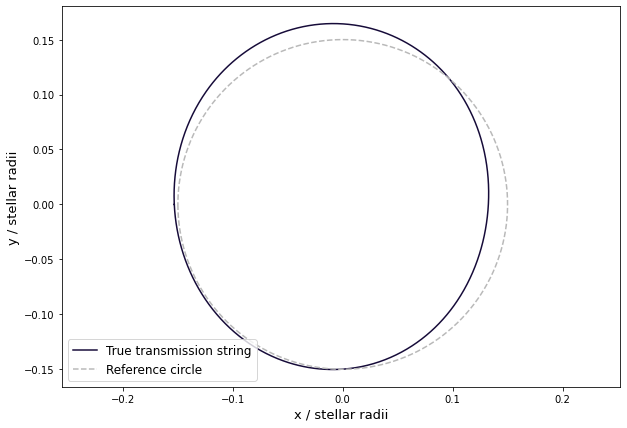

In [2]:
print("r = {0:.3f}{1:+.3f}cos(t){2:+.3f}sin(t){3:+.3f}cos(2t)".format(*injected_r))

plt.figure(figsize=(10, 7))
plt.gca().set_aspect("equal", "datalim")
plt.plot(injected_transmission_string * np.cos(theta), 
         injected_transmission_string * np.sin(theta), 
         c=cm.inferno(0.1), label="True transmission string")
plt.plot(injected_r[0] * np.cos(theta), injected_r[0] * np.sin(theta), 
         c="#b9b9b9", ls="--", label="Reference circle")
plt.xlabel("x / stellar radii", fontsize=13)
plt.ylabel("y / stellar radii", fontsize=13)
plt.legend(loc="lower left", fontsize=12)
plt.show()

Now, following the [maximum likelihood tutorial](<mle_transmission_string.html>), you can apply Harmonica with successively more and more transmission string parameters. For each fit you can calculate some model selection metric, such as the Bayesian information criterion (BIC), and use this to inform how much model complexity is justified by the data.

In [3]:
from scipy.optimize import curve_fit


def transit_model(_, *params):
    ht.set_planet_transmission_string(np.array(params))
    model = ht.get_transit_light_curve()

    return model


def bic(model, n):
    ln_max_likelihood = -0.5 * np.sum((observed_fluxes - model)**2 / flux_sigma**2 
                                      + np.log(2 * np.pi * flux_sigma**2))
    k = injected_r.shape[0]
    bic = k * np.log(n) - 2. * ln_max_likelihood
    
    return bic


n_params = np.arange(1, 7, 1)
bic_scores = []
mle_transmission_strings = []
for n_p in n_params:
    
    popt, pcov = curve_fit(
        transit_model, times, observed_fluxes, sigma=flux_sigma,
        p0=np.concatenate([r_mean, np.zeros(n_p - 1)]),
        method='lm')
    
    bic_score = bic(transit_model(times, *popt), n_p)
    bic_scores.append(bic_score)
    
    ht.set_planet_transmission_string(np.array(popt))
    transmission_string = ht.get_planet_transmission_string(theta)
    mle_transmission_strings.append(transmission_string)

After the fitting is complete you can plot the BIC scores. Note it is only the relative scores which matter, and so we transform the scores for easier visualisation.

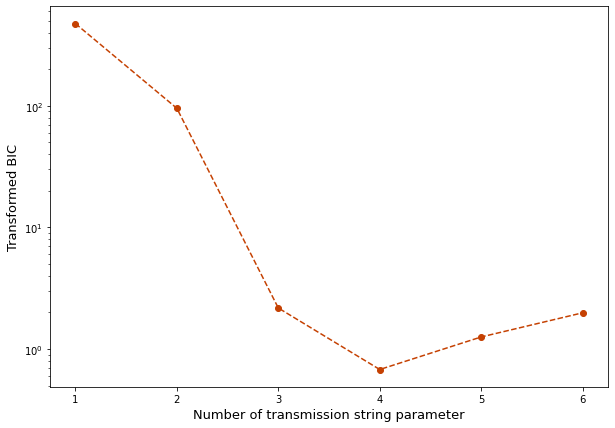

In [4]:
bic_scores_tf = np.array(bic_scores) - np.floor(np.min(bic_scores))

plt.figure(figsize=(10, 7))
plt.plot(n_params, bic_scores_tf, color=cm.Oranges(0.8), ls="--")
plt.scatter(n_params, bic_scores_tf, color=cm.Oranges(0.8))
plt.yscale("log")
plt.xlabel('Number of transmission string parameter', fontsize=13)
plt.ylabel('Transformed BIC', fontsize=13)
plt.show()

The model with the lowest BIC is generally preferred. Here the model with a 4-parameter transmission string is correctly ascertained to be the statistically preferred model. 

The meaning behind the above trend can be seen more clearly by plotting the MLE transmission strings for each model. Here it can be seen how the model improves substantially between 1 and 4 parameters, but after this any small improvements are not justifed given the number of free parameters.

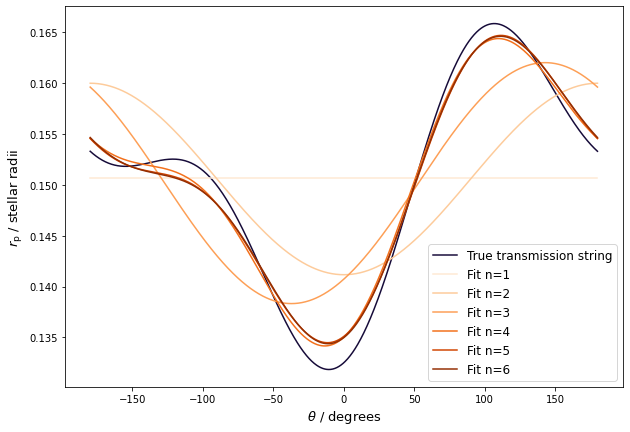

In [5]:
plt.figure(figsize=(10, 7))
plt.plot(theta * 180. / np.pi, injected_transmission_string, 
         c=cm.inferno(0.1), label="True transmission string")
for i, transmission_string in enumerate(mle_transmission_strings):
    plt.plot(theta * 180. / np.pi, transmission_string, 
             color=cm.Oranges(i/len(mle_transmission_strings) + 0.1), label="Fit n={}".format(n_params[i]))

plt.xlabel("$\\theta$ / degrees", fontsize=13)
plt.ylabel("$r_{\\rm{p}}$ / stellar radii", fontsize=13)
plt.legend(loc="lower right", fontsize=12)
plt.show()

Aside from model complexity, the data quality also plays an important role. You can try it yourself, but if you double the data's uncertainties in this tutorial, then the statistically preferred number of parameters drops from 4 to 3.